In [1]:
import pandas as pd
import numpy as np
import h5py
import torch
import torch.nn as nn
import random
import sys
import os

#trying to ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[1]
sys.path.append(os.path.abspath(parent_dir))

In [18]:
experiment_num = 23

In [4]:
#Loading data
with h5py.File('../../data/3d_array/mod_train_data_3d_h5.h5', 'r') as f:
    train_X = f['train_data_3d'][:]
with h5py.File('../../data/3d_array/mod_val_data_3d_h5.h5', 'r') as f:
    val_X = f['val_data_3d'][:]
with h5py.File('../../data/3d_array/mod_test_data_3d_h5.h5', 'r') as f:
    test_X = f['test_data_3d'][:]

train_y = pd.read_parquet('../../data/3d_array/train_targets.parquet')
val_y = pd.read_parquet('../../data/3d_array/val_targets.parquet')
test_y = pd.read_parquet('../../data/3d_array/test_targets.parquet')

In [5]:
train_X = np.nan_to_num(train_X, nan=0.0)
val_X = np.nan_to_num(val_X, nan=0.0)
test_X = np.nan_to_num(test_X, nan=0.0)

In [6]:
train_y['end_of_month'].value_counts()

end_of_month
2018-03-31    289115
Name: count, dtype: int64

In [7]:
train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]
test_y = test_y[test_y['end_of_month'].isin(['2018-03-31'])]

C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_21212\847019464.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_21212\847019464.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]
C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_21212\847019464.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be c

In [8]:
train_y.sort_values(by=['customer_ID'])

,customer_ID,end_of_month,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-31,0
1,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-31,0
2,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,2018-03-31,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2018-03-31,0
4,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2018-03-31,1
...,...,...,...
289110,fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731...,2018-03-31,1
289111,fffef3305f19a11fb6c15f4ebe9be1bd664540e57c0a6a...,2018-03-31,0
289112,ffff39cc22a375d07369980d02d617883dd28ad81a6aa3...,2018-03-31,0
289113,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2018-03-31,0


In [9]:
train_X.shape, train_y.shape

((289115, 13, 86), (289115, 3))

In [10]:
val_X.shape, val_y.shape

((32124, 13, 86), (32124, 3))

In [11]:
import torch
import torch.nn as nn

class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, pool=True, dropout=0.3):
        super(ResidualConvBlock, self).__init__()

        # --- Main Path ---
        # Convolution -> BatchNorm -> ReLU
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, bias=False) # Bias False with BN usually
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True) # inplace=True saves a bit of memory

        # --- Shortcut Path ---
        # This path ensures the input ('identity') has the same dimensions (channels)
        # as the output of the main path before addition.
        self.shortcut = nn.Sequential() # Default: do nothing (if channels match)
        if in_channels != out_channels:
            # If channels differ, use a 1x1 Conv to project the identity
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        # Note: If pooling happened *before* the addition point, the shortcut would also need pooling.
        # But we add *before* pooling here, so it's simpler.

        # --- Post-Addition Layers (same as original ConvBlock) ---
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2) if pool else nn.Identity() # Use stride=2 for standard MaxPool
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Store the input for the shortcut path, applying projection if needed
        identity = self.shortcut(x)

        # Calculate the main path output
        out = self.conv(x)
        out = self.bn(out)
        # ReLU is applied *after* adding the shortcut in ResNet

        # Add the shortcut (identity or projected identity) to the main path output
        out += identity
        # Apply activation function *after* the addition
        out = self.relu(out)

        # Apply pooling (optional) and dropout after the residual connection is formed
        out = self.pool(out)
        out = self.dropout(out)

        return out

In [12]:
class ResConvModel(nn.Module):
    def __init__(self, input_size, output_size=1):
        super(ResConvModel, self).__init__()

        # Use ResidualConvBlock instead of the original ConvBlock
        # Pass the same parameters as originally intended

        # First residual block (pools by default based on original model)
        self.block1 = ResidualConvBlock(input_size, 32, pool=True)

        # Second residual block (pools by default)
        self.block2 = ResidualConvBlock(32, 64, pool=True)

        # Third residual block (no pooling as specified in original model)
        self.block3 = ResidualConvBlock(64, 128, pool=False)

        # Global pooling (remains the same)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers (remains the same, added ReLU)
        self.fc1 = nn.Linear(128, 64) # Input from global pooling (128 channels)
        self.fc_relu = nn.ReLU()     # Added ReLU
        self.fc2 = nn.Linear(64, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: batch_size x time_steps x features
        # For Conv1D: convert to batch_size x features(channels) x time_steps
        x = x.permute(0, 2, 1)

        # Pass through residual blocks
        # The pooling happens *inside* each block if pool=True
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # Global pooling to get fixed-size representation
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1) # Flatten (batch_size, 128)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc_relu(x) # Apply ReLU
        x = self.fc2(x)

        # Output probability
        return self.sigmoid(x)

In [13]:
# Initialize the ConvModel
input_size = train_X.shape[2]  # Number of features
output_size = 1  # Binary classification

# Create model instance
model = ResConvModel(input_size=input_size, output_size=output_size)
print(f"Model initialized with input_size={input_size}, output_size={output_size}")

Model initialized with input_size=86, output_size=1


In [14]:
batch_size = 10000
from torchinfo import summary
summary(model, input_size=(batch_size, train_X.shape[1], train_X.shape[2]), device='cpu',
        col_names=["input_size", "kernel_size","output_size", "num_params"], depth = 1)

Layer (type:depth-idx)                   Input Shape               Kernel Shape              Output Shape              Param #
ResConvModel                             [10000, 13, 86]           --                        [10000, 1]                --
├─ResidualConvBlock: 1-1                 [10000, 86, 13]           --                        [10000, 32, 6]            11,136
├─ResidualConvBlock: 1-2                 [10000, 32, 6]            --                        [10000, 64, 3]            8,448
├─ResidualConvBlock: 1-3                 [10000, 64, 3]            --                        [10000, 128, 3]           33,280
├─AdaptiveAvgPool1d: 1-4                 [10000, 128, 3]           --                        [10000, 128, 1]           --
├─Linear: 1-5                            [10000, 128]              --                        [10000, 64]               8,256
├─ReLU: 1-6                              [10000, 64]               --                        [10000, 64]               --
├─Lin

In [15]:
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        """
        Args:
            data: numpy array of shape (num_ids, time_steps, features)
            targets: numpy array of shape (num_ids,)
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)  # Add dimension for output
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [16]:
train_dataset = TimeSeriesDataset(train_X, train_y['target'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [17]:
val_dataset = TimeSeriesDataset(val_X, val_y['target'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [19]:
test_dataset = TimeSeriesDataset(test_X, test_y['target'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
train_dataset.__getitem__(0)[0].shape, train_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([0.]))

In [21]:
val_dataset.__getitem__(0)[0].shape, val_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([1.]))

In [22]:
from sklearn.metrics import roc_auc_score
import time
import copy
from tqdm.auto import tqdm

import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 20
patience = 3  # Number of epochs to wait for improvement before early stopping

# Initialize variables for early stopping
best_val_loss = float('inf')
best_val_auc = 0.0
best_model_wts = copy.deepcopy(model.parameters)
no_improve_epochs = 0

# For tracking metrics
train_losses = []
val_losses = []
val_aucs = []

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Training on {device}")
start_time = time.time()

# Training loop

# Modify the training loop to include progress bars
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    # Add tqdm progress bar for training loop
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        # Update progress bar with current loss
        train_pbar.set_postfix({'loss': loss.item()})
    
    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Add tqdm progress bar for validation loop
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]", leave=False)
    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            # Collect predictions and labels for AUC calculation
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar with current loss
            val_pbar.set_postfix({'loss': loss.item()})
    
    # Calculate metrics
    epoch_val_loss = running_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    all_preds = [p[0] for p in all_preds]  # Flatten predictions
    all_labels = [l[0] for l in all_labels]  # Flatten labels
    epoch_val_auc = roc_auc_score(all_labels, all_preds)
    val_aucs.append(epoch_val_auc)
    
    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val AUC: {epoch_val_auc:.4f}")
    
    # Check if this is the best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_val_auc = epoch_val_auc
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    
    # Early stopping
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


# Training complete
time_elapsed = time.time() - start_time
print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
print(f"Best val loss: {best_val_loss:.4f}, Best val AUC: {best_val_auc:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)

Training on cuda:0


Epoch 1/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 0.4569, Val Loss: 0.3070, Val AUC: 0.9242


Epoch 2/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 2/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 0.2974, Val Loss: 0.2849, Val AUC: 0.9372


Epoch 3/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 0.2798, Val Loss: 0.2717, Val AUC: 0.9430


Epoch 4/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 0.2720, Val Loss: 0.2647, Val AUC: 0.9455


Epoch 5/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 0.2663, Val Loss: 0.2571, Val AUC: 0.9472


Epoch 6/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 6/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 0.2634, Val Loss: 0.2596, Val AUC: 0.9479


Epoch 7/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 7/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20 - Train Loss: 0.2602, Val Loss: 0.2545, Val AUC: 0.9489


Epoch 8/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 8/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20 - Train Loss: 0.2581, Val Loss: 0.2520, Val AUC: 0.9496


Epoch 9/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 9/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20 - Train Loss: 0.2562, Val Loss: 0.2521, Val AUC: 0.9502


Epoch 10/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 10/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 0.2543, Val Loss: 0.2515, Val AUC: 0.9506


Epoch 11/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 11/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 0.2537, Val Loss: 0.2489, Val AUC: 0.9509


Epoch 12/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 12/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 0.2527, Val Loss: 0.2561, Val AUC: 0.9511


Epoch 13/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 13/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 0.2522, Val Loss: 0.2464, Val AUC: 0.9514


Epoch 14/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 14/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20 - Train Loss: 0.2512, Val Loss: 0.2495, Val AUC: 0.9516


Epoch 15/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 15/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20 - Train Loss: 0.2506, Val Loss: 0.2449, Val AUC: 0.9519


Epoch 16/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 16/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20 - Train Loss: 0.2497, Val Loss: 0.2486, Val AUC: 0.9521


Epoch 17/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 17/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20 - Train Loss: 0.2493, Val Loss: 0.2439, Val AUC: 0.9523


Epoch 18/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 18/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20 - Train Loss: 0.2486, Val Loss: 0.2433, Val AUC: 0.9525


Epoch 19/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 19/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20 - Train Loss: 0.2490, Val Loss: 0.2466, Val AUC: 0.9526


Epoch 20/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 20/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20 - Train Loss: 0.2482, Val Loss: 0.2492, Val AUC: 0.9523
Training completed in 1m 24s
Best val loss: 0.2433, Best val AUC: 0.9525


<All keys matched successfully>

In [23]:
import os

# Save the model weights

# Create directory if it doesn't exist
save_dir = '../../models/deep_learning'
os.makedirs(save_dir, exist_ok=True)

# Save model state dictionary
model_path = os.path.join(save_dir, f'experiment_{experiment_num}.pth')
torch.save(model.state_dict(), model_path)

# Save additional information for later reference
checkpoint_path = os.path.join(save_dir, f'experiment_{experiment_num}.pth')
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(checkpoint, checkpoint_path)

print(f"Model saved to {model_path}")
print(f"Checkpoint saved to {checkpoint_path}")

Model saved to ../../models/deep_learning\experiment_23.pth
Checkpoint saved to ../../models/deep_learning\experiment_23.pth


In [24]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize a list to store predictions
val_predictions = []

# Disable gradient computation for inference
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        val_predictions.extend(outputs.cpu().numpy())

# Flatten the predictions
val_predictions = [p[0] for p in val_predictions]
print("Validation predictions obtained.")

Validation predictions obtained.


Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.6969782
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8569    0.9800    0.9143     23806
     Class 1     0.9028    0.5316    0.6692      8318

    accuracy                         0.8639     32124
   macro avg     0.8799    0.7558    0.7918     32124
weighted avg     0.8688    0.8639    0.8509     32124



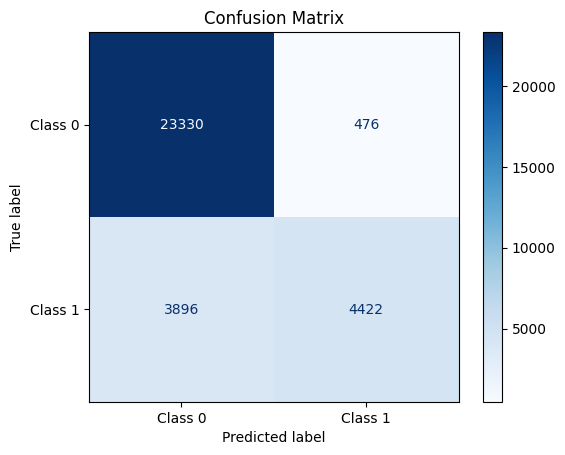

0.6969781517982483

In [25]:
from utils.eval_helpers import evaluate_model_for_recall
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=np.array(all_labels).astype('int'), y_pred_proba=np.array(val_predictions))

In [26]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Set model to evaluation mode
model.eval()

# Check if CUDA is available and move model to the appropriate device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lists to store predictions and true values
all_preds = []
all_labels = []

# Perform inference without gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Store predictions and labels
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Convert predictions to binary (0 or 1) using threshold of 0.5
pred_classes = (all_preds > 0.5).astype(int)
true_classes = all_labels.astype(int)

# Generate classification report

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, pred_classes, digits = 4))

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print ROC-AUC score
auc = roc_auc_score(true_classes, all_preds)
print(f"ROC-AUC Score: {auc:.4f}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0     0.9089    0.9423    0.9253    102026
           1     0.8155    0.7298    0.7703     35648

    accuracy                         0.8873    137674
   macro avg     0.8622    0.8361    0.8478    137674
weighted avg     0.8848    0.8873    0.8852    137674

Accuracy: 0.8873
ROC-AUC Score: 0.9505

Confusion Matrix:
[[96141  5885]
 [ 9631 26017]]


Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.6934441
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8558    0.9800    0.9137    102026
     Class 1     0.9021    0.5275    0.6657     35648

    accuracy                         0.8628    137674
   macro avg     0.8790    0.7537    0.7897    137674
weighted avg     0.8678    0.8628    0.8495    137674



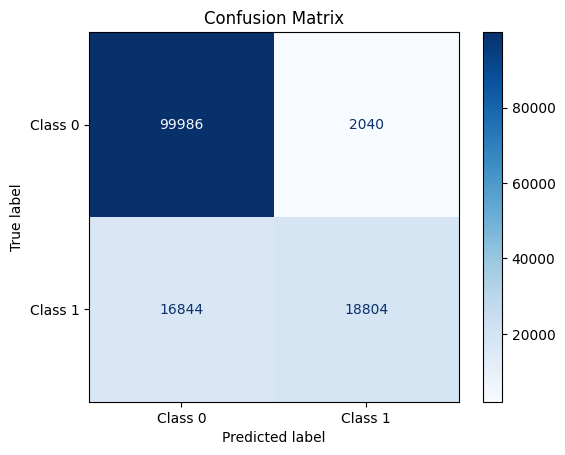

0.6934441328048706

In [27]:
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=true_classes, y_pred_proba=all_preds)